In [ ]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import numpy as np
import pandas as pd
import argparse
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import shuffle

import tensorflow as tf
import sklearn as sk
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [ ]:
!wget https://github.com/stratosphereips/StratosphereLinuxIPS/blob/master/modules/rnn-cc-detection/datasets/dataset_more_labels.dat

--2023-03-31 17:59:07--  https://github.com/stratosphereips/StratosphereLinuxIPS/blob/master/modules/rnn-cc-detection/datasets/dataset_more_labels.dat
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset_more_labels.dat’

dataset_more_labels     [ <=>                ] 960.03K  --.-KB/s    in 0.04s   

2023-03-31 17:59:07 (24.0 MB/s) - ‘dataset_more_labels.dat’ saved [983070]



In [ ]:
# Load the dataset
# Cut the max amount of letters in the state to a maximum.
# Better to do it here in the read_csv so we dont use memory later. Here those lines never go into memory.
max_letters = 500
f = lambda x: x[: max_letters]
with open('./dataset_more_labels.dat', 'rb') as csvfile:
    df = pd.read_csv(
        csvfile,
        delimiter='|',
        names=['note', 'label', 'model_id', 'state'],
        skipinitialspace=True,
        converters={'state': f},
    )

# Print dataset information
print(f'Numpy: {np.__version__}')
print(f'TensorFlow: {tf.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Sklearn: {sk.__version__}')
df.describe()

Numpy: 1.22.4
TensorFlow: 2.12.0
Pandas: 1.4.4
Sklearn: 1.2.2


,note,label,model_id,state
count,1445,66,66,1445
unique,835,65,62,63
top,</div>,From-Botnet-TCP-HTTP-Bing-1 ...,[36m10.0.2.104-147.32.83.57-5552-tcp[0m ...,
freq,98,2,2,1379


In [ ]:
df

,note,label,model_id,state
0,<!DOCTYPE html>,NaN,NaN,
1,"<html lang=""en"" data-color-mode=""auto"" data-li...",NaN,NaN,
2,<head>,NaN,NaN,
3,"<meta charset=""utf-8"">",NaN,NaN,
4,"<link rel=""dns-prefetch"" href=""https://github....",NaN,NaN,
...,...,...,...,...
1440,</template>,NaN,NaN,
1441,</div>,NaN,NaN,
1442,"<div id=""js-global-screen-reader-notice"" class...",NaN,NaN,
1443,</body>,NaN,NaN,


In [ ]:
# Clean the dataset
df.dropna(axis=0, how='any', inplace=True)
df.drop(axis=1, columns=['note', 'model_id'], inplace=True)

# Delete the strings of letters with less than a certain amount
min_letters = 5
indexNames = df[df['state'].str.len() < min_letters].index
df.drop(indexNames, inplace=True)

In [ ]:
# Add a new column to the dataframe with the label. The label is 'Normal' for the normal data and 'Malcious' for the malware data
df.loc[df.label.str.contains('Normal'), 'label'] = 'Normal'
df.loc[df.label.str.contains('Botnet'), 'label'] = 'Malicious'
df.loc[df.label.str.contains('Malware'), 'label'] = 'Malicious'

# Change the labels from Malicious/Normal to 1/0 integers in the df
df.label.replace('Malicious', 1, inplace=True)
df.label.replace('Normal', 0, inplace=True)



In [ ]:
verbose=True
df

,label,state
1051,1,55.v.e.e.E.v.e.E.v.E.E.v.v.e.v.v.e.e.e.e.v.v.e...
1055,1,"22,b,b,S*S,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b..."
1059,1,"11*R,R.r.R.r.r.r.R.r.r.r.r.v.v.B.B.r.A.r.A.R.R..."
1063,1,11.0000000000000000000000000000000000000000000...
1067,1,12*S+b+b+b+a+b+b+a+a+a+00RR+A+00000000000SS+b+...
...,...,...
1295,0,5</td>
1299,0,5</td>
1303,1,"11.R,R.R,R.R,R.R.R.R.R.R.R.R.</td>"
1307,0,"44.v.U+U.d.u.V.V.V.D.V.U.u.u.U.V+d+U.V.U+U,U.U..."


In [ ]:
# Convert each of the stratosphere letters to an integer. There are 50
vocabulary = list('abcdefghiABCDEFGHIrstuvwxyzRSTUVWXYZ1234567890,.+*')
int_of_letters = {}
for i, letter in enumerate(vocabulary):
    int_of_letters[letter] = float(i)

# Change the letters in the state to an integer representing it uniquely. We 'encode' them.
def encode_state(state):
    encoded_state = []
    for i in state:
        if i in int_of_letters:
            encoded_state.append([int_of_letters[i]])
        else:
            new_index = max(int_of_letters.values()) + 1
            int_of_letters[i] = float(new_index)
            vocabulary.append(i)
            encoded_state.append([new_index])
    return encoded_state

df['state'] = df['state'].apply(encode_state)

if verbose:
    print(
        f'There are {len(int_of_letters)} letters in total. From letter index {min(int_of_letters.values())} to letter index {max(int_of_letters.values())}.'
    )
vocabulary_size = len(int_of_letters)
features_per_sample = 1

There are 53 letters in total. From letter index 0.0 to letter index 52.0.


In [ ]:
vocabulary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '0',
 ',',
 '.',
 '+',
 '*',
 '<',
 '/',
 '>']

There are 66 outtuples
There are 66 labels
The max len of the letters in all outtuples is: 500
x_data type <class 'numpy.ndarray'> of shape (66,). x_data[0] type is <class 'list'>
x_data[0] is [[40.0], [40.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [13.0], [47.0], [22.0], [47.0], [4.0], [47.0], [13.0], [47.0], [22.0], [47.0], [13.0], [47.0], [13.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [4.0], [47.0], [22.0], [47.0], [13.0], [47.0], [13.0], [47.0], [13.0], [47.0], [22.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], [4.0], [47.0], [22.0], [47.0], [22.0], [47.0], 

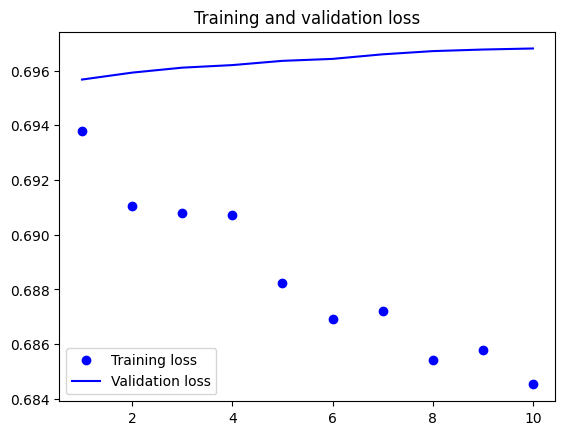

In [ ]:
# Convert the data into the appropriate shape
# x_data is a list of lists. The 1st dimension is the outtuple, the second the letter. Each letter is now an int value. shape=(num_outuples, features_per_sample)
x_data = df['state'].to_numpy()
if verbose:
    print('There are {} outtuples'.format(len(x_data)))
# y_data is a list of ints that are 0 or 1. One integer per outtupple. shape=(num_outuples, 1)
y_data = df['label'].to_numpy()
if verbose:
    print('There are {} labels'.format(len(y_data)))
# Search the sample with max len in the training. It should be already cuted by the csv_read function to a max. Here we just check
max_length_of_outtupple = max([len(sublist) for sublist in df.state.to_list()])
if verbose:
    print(
        'The max len of the letters in all outtuples is: {}'.format(
            max_length_of_outtupple
        )
    )

# Here x_data is a array of lists [[]]
if verbose:
    print(
        f'x_data type {type(x_data)} of shape {x_data.shape}. x_data[0] type is {type(x_data[0])}'
    )
    print(f'x_data[0] is {x_data[0]}')



# Padding.
# Since not all outtuples have the same amount of letters, we need to add padding at the end
# Transforms the list to a 2D Numpy array of shape (num_samples, num_timesteps)
# num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.
# Sequences that are shorter than num_timesteps are padded with value at the end.
# padding: 'pre' or 'post': pad either before or after each sequence.
# truncating: 'pre' or 'post': remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.

# If the input is a string
# padded_x_data = pad_sequences(x_data, maxlen=max_length_of_outtupple, padding='post', value='0', dtype=object )

# If the input are integers
padded_x_data = pad_sequences(
    x_data, maxlen=max_length_of_outtupple, padding='post'
)
if verbose:
    print(
        f'padded_x_data is of type {type(padded_x_data)}, of shape {padded_x_data.shape}. padded_x_data[0] type is {type(padded_x_data[0])}. Shape of second list is {padded_x_data[0].shape}'
    )


# Split the data in training and testing
# train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True)

# For now, just use all the data

# Split the one-hot
# train_x_data = x_data_oh
# train_y_data = y_data

# Split the padded data only without one-hot
train_x_data = padded_x_data
train_y_data = y_data


# Hyperparameters
# Real data
# Store the dimensions
# batch_size = 100 # group of outtuples as a batch
num_outtuples = train_x_data.shape[0]   # number_of_outtuples in general
# max_length_of_outtupple # max amount of letters in each outtuple (500 now)

# In the case of hot-encoding, the amount of features per letter per sample, is 50, which is the vocabulary size
# features_per_sample = vocabulary_size # amount of positions of the hot encoding (50 letters, so 50)
# print(f'We have as input shape: {num_outtuples}, {max_length_of_outtupple}, {features_per_sample}')
# input_shape = (max_length_of_outtupple, features_per_sample)

# In the case of not using hot-encoding, the amount of features per sample is 1, because we only have one value
# The amount of time steps is the amount of letters, since one letter is one time step, which is the amount of letters max, which 500
timesteps = max_length_of_outtupple
input_shape = (timesteps, features_per_sample)
print(
    f'We have as shape: Num of samples: {num_outtuples}, Num of letters per sample (timesteps): {timesteps}, each letter has {features_per_sample} values. The input shape is {input_shape}'
)

# num_epochs = 500

# The shape of the input is now : (2200, 500, 50)
# 2200, amount of outtuples
# 500, is the padded amount of letters in each outtuple
# 50, the one hot on the amount of letters


# Create the model of RNN
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocabulary_size, 16, mask_zero=True))
# GRU is the main RNN layer, inputs: A 3D tensor, with shape [batch, timesteps, feature]
model.add(
    layers.Bidirectional(
        layers.GRU(32, return_sequences=False), merge_mode='concat'
    )
)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# Fully connected layer with 1 neuron output
# Final output value between 0 and 1 as probability
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.05),
    metrics=['accuracy'],
)


# Train the model
# This is already separating in trainign and validation
history = model.fit(
    train_x_data,
    train_y_data,
    epochs=10,
    batch_size=100,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
    
)

if verbose:
    model.summary()
model.save('./gru', overwrite=False)

# To plot the results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('test_results_acc.png')

plt.close()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('test_results_loss.png')


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.1 MB/s eta 0:00:00


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Epoch 1/20
15/15 [==============================] - 34s 427ms/step - loss: 1.9805 - accuracy: 0.5763 - val_loss: 0.9697 - val_accuracy: 0.4286
Epoch 2/20
15/15 [==============================] - 4s 284ms/step - loss: 0.8627 - accuracy: 0.6949 - val_loss: 1.1674 - val_accuracy: 0.4286
Epoch 3/20
15/15 [==============================] - 4s 267ms/step - loss: 0.7787 - accuracy: 0.7966 - val_loss: 0.9719 - val_accuracy: 0.4286
Epoch 4/20
15/15 [==============================] - 4s 252ms/step - loss: 0.7114 - accuracy: 0.7627 - val_loss: 0.9818 - val_accuracy: 0.4286
Epoch 5/20
15/15 [==============================] - 4s 253ms/step - loss: 0.7407 - accuracy: 0.7627 - val_loss: 0.8540 - val_accuracy: 0.4286
Epoch 6/20
15/15 [==============================] - 4s 252ms/step - loss: 0.7259 - accuracy: 0.7288 - val_loss: 1.0045 - val_accuracy: 0.4286
Epoch 7/20
15/15 [==============================] - 4s 263ms/step - loss: 0.6638 - accuracy: 0.7966 - val_loss: 0.9442 - val_accuracy: 0.4286
Epoch

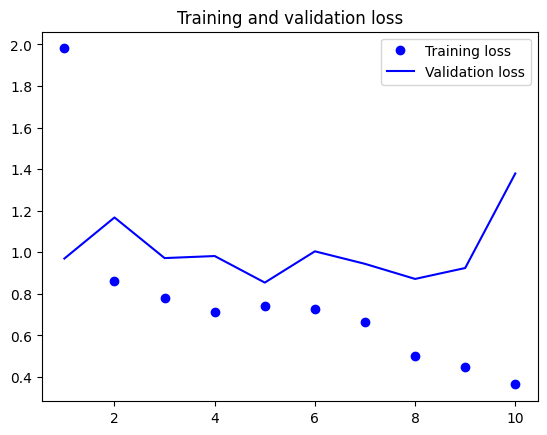

In [ ]:
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Load the pre-trained transformer model and tokenizer
model_name = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
transformer_model = TFGPT2Model.from_pretrained(model_name)

# Define the input shape
max_length = max_length_of_outtupple
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)

# Convert input sequence to embeddings using transformer
embeddings = transformer_model(input_ids)[0]

# Use a global max pooling layer to reduce the sequence to a fixed size
pooled_output = tf.keras.layers.GlobalMaxPooling1D()(embeddings)

# Add a fully connected layer with a sigmoid activation to predict the DGA probability
fc_layer = tf.keras.layers.Dense(
    64,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
)(pooled_output)
dropout_layer = tf.keras.layers.Dropout(0.5)(fc_layer)
fc_layer = tf.keras.layers.Dense(
    32,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
)(dropout_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(fc_layer)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(dropout_layer)

# Create the model
model = tf.keras.models.Model(inputs=input_ids, outputs=predictions)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
history = model.fit(
    train_x_data,
    train_y_data,
    epochs=20,
    batch_size=4,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping],
)

if verbose:
    model.summary()

# To plot the results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('test_results_acc.png')

plt.close()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('test_results_loss.png')
